<a href="https://colab.research.google.com/github/R4-P1-201/m1MesaTarea/blob/main/Mesa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random

import time
import datetime

In [ ]:
def obtener_habitacion(modelo):
  habitacion = np.zeros((modelo.grid.width, modelo.grid.height))
  for celda in modelo.grid.coord_iter():
    contenido_celda, x, y = celda
    for contenido in contenido_celda:
      if isinstance(contenido, Aspiradora):
        habitacion[x][y] = 2
      else:
        habitacion[x][y] = contenido.estado
  return habitacion



class Aspiradora(Agent):
  def __init__(self, id_unico, modelo):
    super().__init__(id_unico,modelo)
    self.nueva_posicion = None
    self.movimientos = 0

  def step(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos,
        moore = True,
        include_center = True)
    
    for vecino in vecinos:
      if isinstance(vecino, Piso) and vecino.pos == self.pos:
        vecino.siguiente_estado = vecino.estado
        if vecino.siguiente_estado == vecino.SUCIO:
            vecino.siguiente_estado = vecino.LIMPIO
            self.nueva_posicion = self.pos
        else:
          vecindario = self.model.grid.get_neighborhood(
              self.pos,
              moore = True,
              include_center = False)
          nueva_posicion = self.random.choice(vecindario)
          self.nueva_posicion = nueva_posicion
        break
    
  def advance(self):
    vecinos = self.model.grid.get_neighbors(
      self.pos,
      moore = False,
      include_center = True)
  
    for vecino in vecinos:
      if isinstance(vecino, Piso ) and vecino.pos == self.pos:
        vecino.estado = vecino.siguiente_estado
        break

    if self.pos != self.nueva_posicion:
      self.movimientos = self.movimientos + 1

    self.model.grid.move_agent(self, self.nueva_posicion)

class Piso(Agent):
  SUCIO = 1
  LIMPIO = 0 

  def __init__(self, pos, modelo, estado=LIMPIO):
    super().__init__(pos,modelo)
    self.x,self.y = pos 
    self.estado = estado
    self.siguiente_estado = None

class Habitacion(Model):
  
  def __init__(self, m, n, num_agentes, por_celdas_sucias):
    self.num_agentes = num_agentes
    self.por_celdas_sucias = por_celdas_sucias
    self.por_celdas_limpias = 1 - por_celdas_sucias
    self.grid = MultiGrid(m, n, True)
    self.schedule = SimultaneousActivation(self)

    celdas_sucias = int ((m*n) * por_celdas_sucias)
    lista_celdas_vacias = list(self.grid.empties)

    for celdas in range(celdas_sucias):
      celda_vacia = random.choice(lista_celdas_vacias)
      piso = Piso(celda_vacia,self)
      piso.estado = piso.SUCIO
      self.grid.place_agent(piso,celda_vacia)
      self.schedule.add(piso)
      lista_celdas_vacias.remove(celda_vacia)

    lista_celdas_vacias = list(self.grid.empties)
    for celdas in lista_celdas_vacias:
      piso = Piso(celdas, self)
      self.grid.place_agent(piso, celdas)
      self.schedule.add(piso)

    for i in range(num_agentes):
      aspiradora = Aspiradora(i, self)
      self.grid.place_agent(aspiradora,(1,1))
      self.schedule.add(aspiradora)

    self.colectordatos = DataCollector(
        model_reporters={'Habitacion': obtener_habitacion},
        agent_reporters={'Movimientos': lambda a: getattr(a,'movimientos',None)}

    )

  def step(self):
    self.colectordatos.collect(self)
    self.schedule.step()

  def todasceldaslimpias(self):
    celdas_limpias = 0
    for celda in self.grid.coord_iter():
        contenido_celda, x, y = celda
        for  contenido in contenido_celda:
              if isinstance(contenido, Piso) and contenido.estado == contenido.LIMPIO:
                  celdas_limpias = celdas_limpias + 1
    self.por_celdas_limpias = celdas_limpias / (self.grid.width * self.grid.height)
    if self.por_celdas_limpias == 1:  
      return True
    else:
      return False

In [ ]:
M = 15
N = 15

NUM_AGENTES = 80

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

start_time = time.time()
tiempo_inicio = str(datetime.timedelta(seconds=TIEMPO_MAXIMO_EJECUCION))
modelo = Habitacion(M,N, NUM_AGENTES, PORCENTAJE_CELDAS_SUCIAS)

while((time.time() - start_time) < TIEMPO_MAXIMO_EJECUCION and not modelo.todasceldaslimpias()):
  modelo.step()


tiempo_ejecucion = str(datetime.timedelta(seconds=(time.time() - start_time)))

In [ ]:
todas_habitaciones = modelo.colectordatos.get_model_vars_dataframe()

In [ ]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(todas_habitaciones.iloc[0][0], cmap ='Greys')

def animate(i):
  patch.set_data(todas_habitaciones.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=len(todas_habitaciones))

In [ ]:
anim

In [ ]:
movimientos = modelo.colectordatos.get_agent_vars_dataframe()
print('Tiempo necesario hasta que todas las celdas se encuentren limpias: ', tiempo_ejecucion, '/', tiempo_inicio)
print('Porcentaje de celdas limpias después del termino de la simulación: ', modelo.por_celdas_limpias)
print('Número de movimientos realizados por todos los agentes: ', movimientos.tail()['Movimientos'].sum())

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061864 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8666666666666667
Número de movimientos realizados por todos los agentes:  81.0


Prueba 1 (40 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060716 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8888888888888888
Número de movimientos realizados por todos los agentes:  117.0

Prueba 1.1 (40 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061864 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.88
Número de movimientos realizados por todos los agentes:  118.0

Prueba 1.2 (40 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061025 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8933333333333333
Número de movimientos realizados por todos los agentes:  119.0

Prueba 2 (30 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061275 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8622222222222222
Número de movimientos realizados por todos los agentes:  146.0

Prueba 2.1 (30 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061411 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.9066666666666666
Número de movimientos realizados por todos los agentes:  154.0

Prueba 2.2 (30 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060988 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.9377777777777778
Número de movimientos realizados por todos los agentes:  163.0

Prueba 3 (20 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061084 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.9155555555555556
Número de movimientos realizados por todos los agentes:  208.0

Prueba 3.1 (20 agentes)  

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060285 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8133333333333334
Número de movimientos realizados por todos los agentes:  158.0

Prueba 3.2 (20 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061064 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8977777777777778
Número de movimientos realizados por todos los agentes:  181.0

Prueba 4 (10 agentes) 

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060442 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8577777777777778
Número de movimientos realizados por todos los agentes:  230.0

Prueba 4.1 (10 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060838 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.88
Número de movimientos realizados por todos los agentes:  252.0

Prueba 4.2 (10 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060452 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8666666666666667
Número de movimientos realizados por todos los agentes:  244.0

Prueba 5 (50 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061983 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8933333333333333
Número de movimientos realizados por todos los agentes:  121.0

Prueba 5.1 (50 agentes) 

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060951 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.9111111111111111
Número de movimientos realizados por todos los agentes:  122.0

Prueba 5.2 (50 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060979 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8711111111111111
Número de movimientos realizados por todos los agentes:  112.0

Prueba 6 (60 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061473 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8222222222222222
Número de movimientos realizados por todos los agentes:  90.0

Prueba 6.1 (60 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061898 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.84
Número de movimientos realizados por todos los agentes:  90.0

Prueba 6.2 (60 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060639 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8888888888888888
Número de movimientos realizados por todos los agentes:  110.0

Prueba 7 (70 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060633 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8622222222222222
Número de movimientos realizados por todos los agentes:  99.0

Prueba 7.1 (70 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060295 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8133333333333334
Número de movimientos realizados por todos los agentes:  82.0

Prueba 7.2 (70 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061188 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8622222222222222
Número de movimientos realizados por todos los agentes:  97.0

Prueba 8 (80 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061948 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8133333333333334
Número de movimientos realizados por todos los agentes:  79.0

Prueba 8.1 (80 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.060697 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8622222222222222
Número de movimientos realizados por todos los agentes:  80.0


Prueba 8.2 (80 agentes) 

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061864 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8666666666666667
Número de movimientos realizados por todos los agentes:  81.0

Prueba 9 (90 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061231 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.7466666666666667
Número de movimientos realizados por todos los agentes:  57.0

Prueba 9.1 (90 agentes)

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.062014 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.8088888888888889
Número de movimientos realizados por todos los agentes:  65.0

Prueba 9.2 (90 agentes) 

PORCENTAJE_CELDAS_SUCIAS = 0.5

TIEMPO_MAXIMO_EJECUCION = 0.06

Tiempo necesario hasta que todas las celdas se encuentren limpias:  0:00:00.061228 / 0:00:00.060000
Porcentaje de celdas limpias después del termino de la simulación:  0.7644444444444445
Número de movimientos realizados por todos los agentes:  73.0

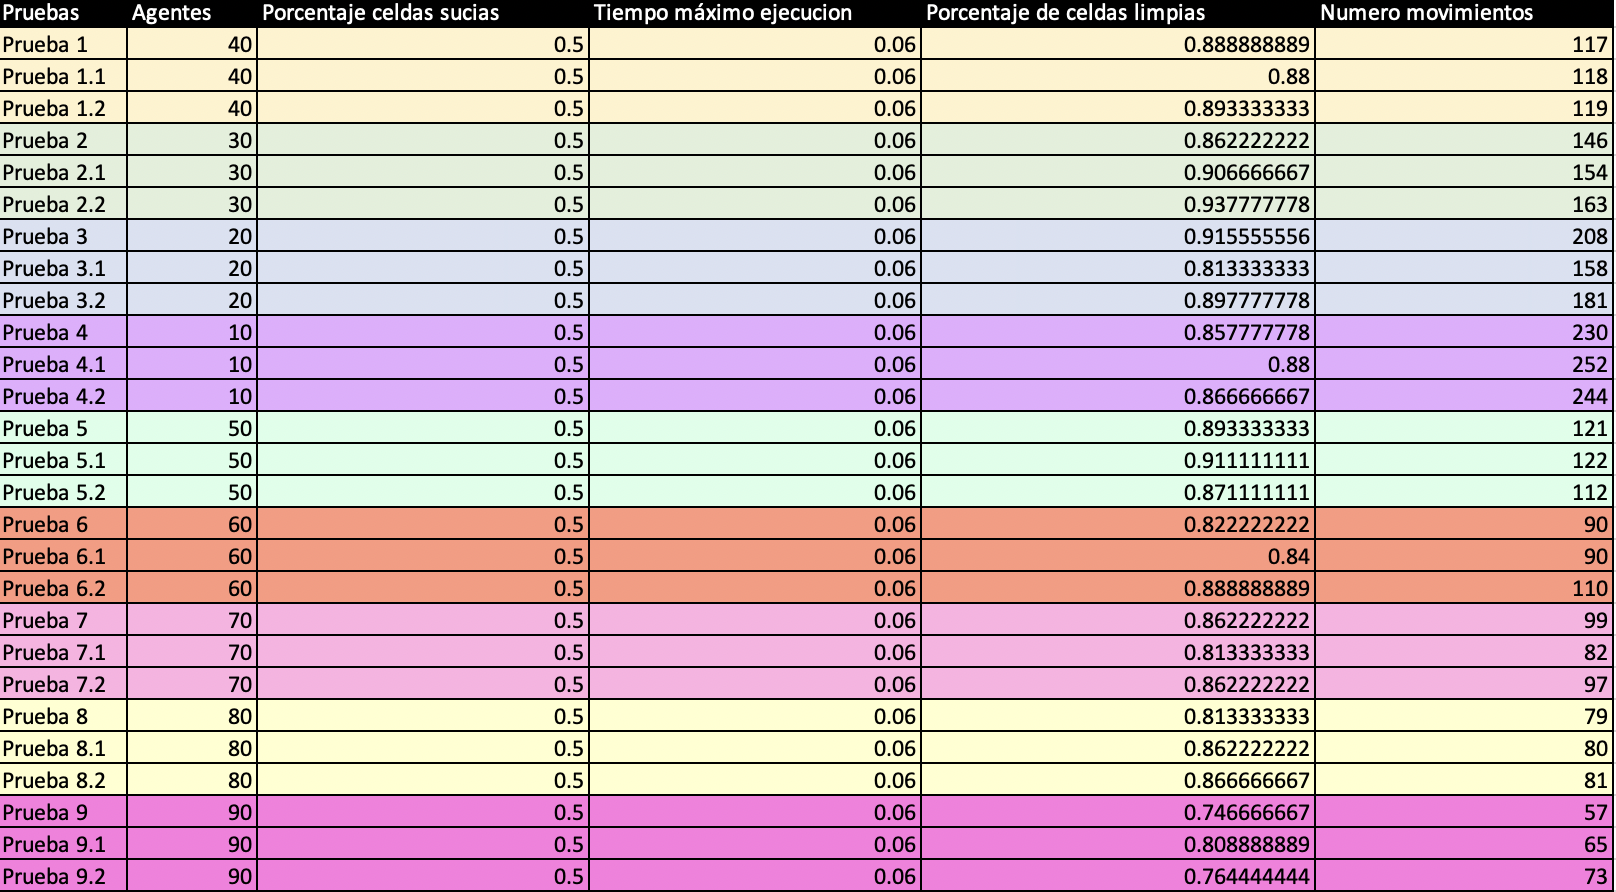

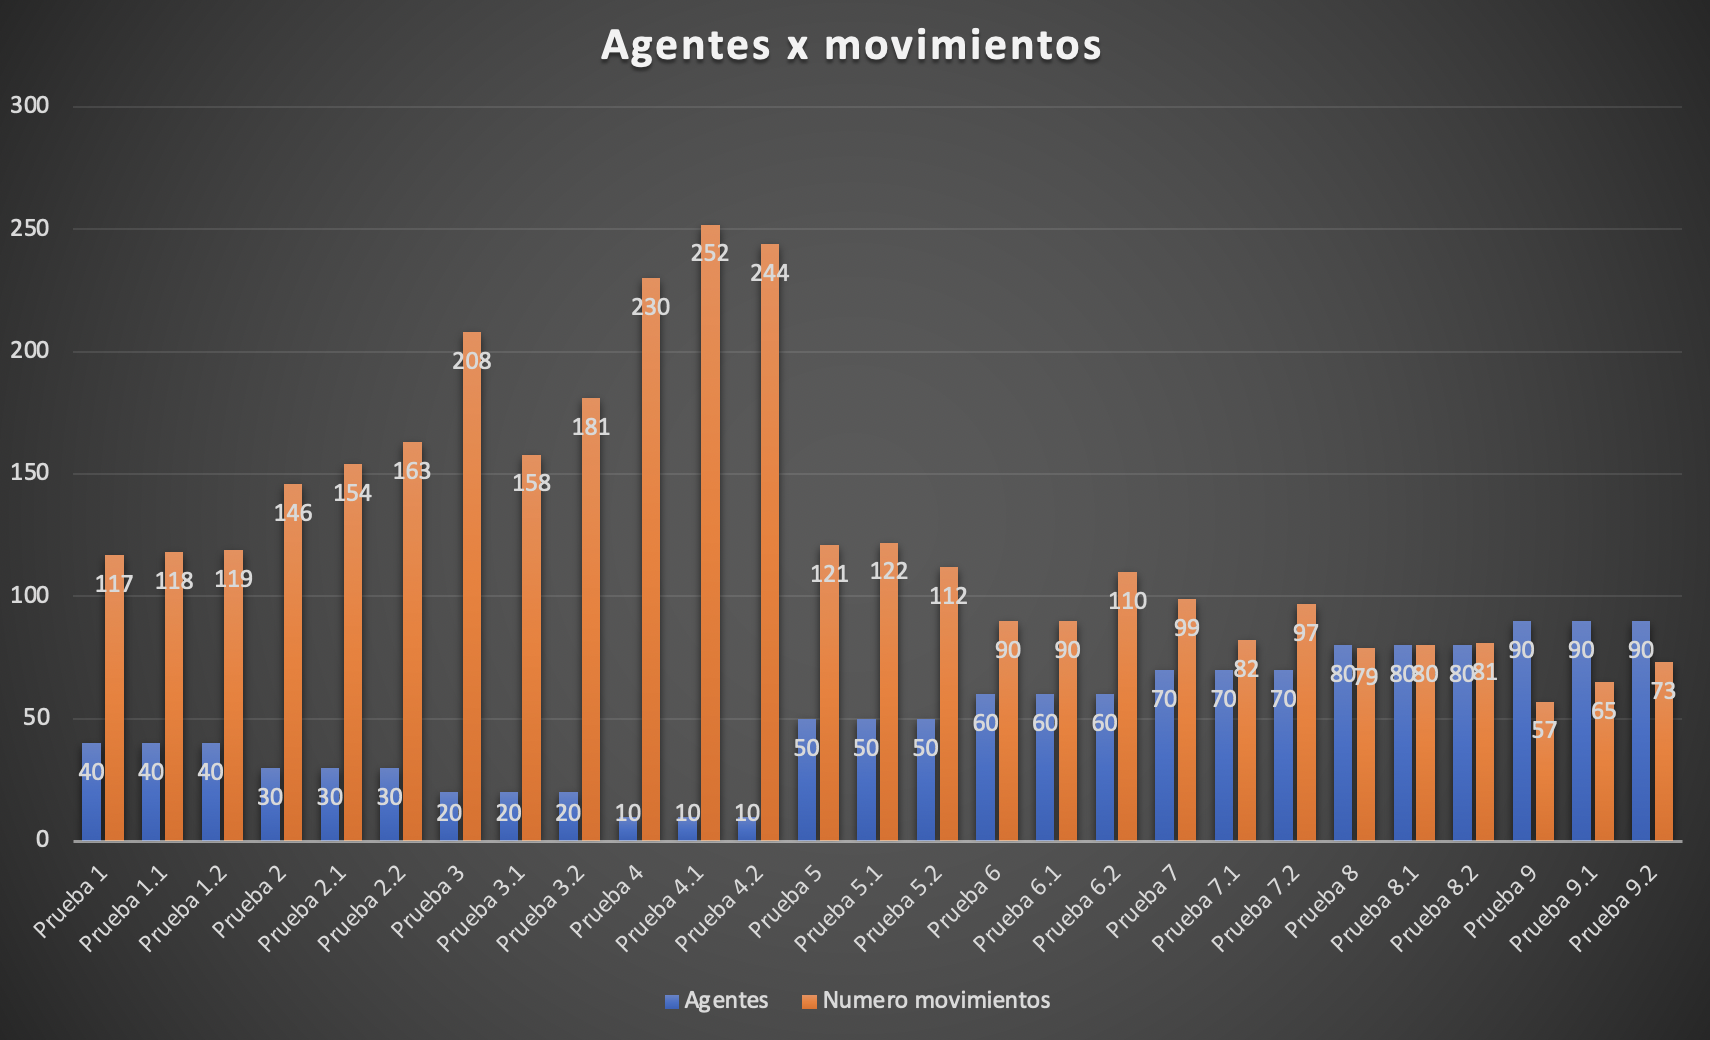

El número de movimientos se reduce cada vez que hay más agentes en el grid, tenemos el mayor número de movimientos cuando solo hay 10 agentes activos.

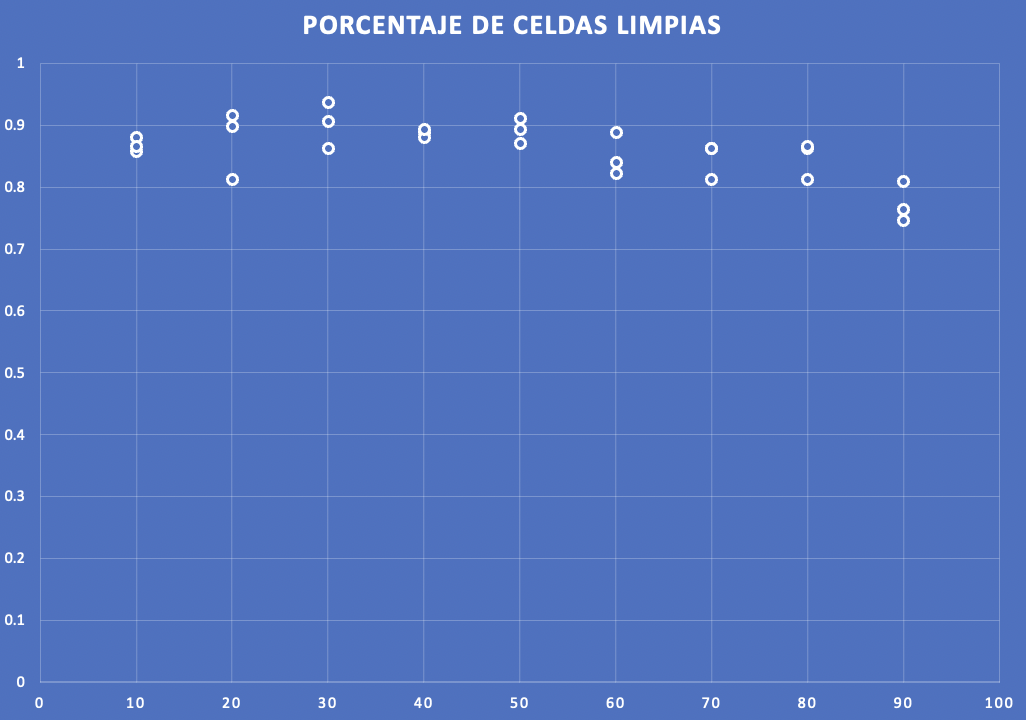

Con el numero de agentes en 30 se obtuvo un mejor resultado en cuanto al número de celdas limpias y con 90 agentes se obtuvo el peor resultado, denotando que una mayor cantidad de aspiradoras no significa que vaya a haber una mayor limpieza. 

Conclusión 

Se pudo concluir al observar el compartamiento del código, que mientras más agentes hay en el grid, podemos inferir por medio de lógica que se tiene una mayor probabilidad de que el porcentaje de celdas limpias sea alto, pero esto no es necesariamente el caso, ya que al tener un mayor numero de agentes en el grid no es igual a que tengamos un mejor rendimiento, todo depende en la forma en la que esten colocados. También se pudo ver un resultado consistente con 80 agentes, el numero de agentes era casi igual al numero de movimientos que se hizo. 

Además, los datos que se obtuvieron nos muestran que aunque se tenga el mismo número de aspiradoras (agentes), los resultados van a variar, esto es así ya que nuestro grid con los lugares sucios y limpio son aleatorios, por lo que el resultado que se obtiene puede ser muy distinto. 